# Convolution Neural Network Using TensorFlow

## Processing the data

In [100]:
import gzip as gz
import numpy as np
from matplotlib import pyplot as plt

In [101]:
train_x = gz.open("Data/train-images-idx3-ubyte.gz", "r")
train_y = gz.open("Data/train-labels-idx1-ubyte.gz", "r")

In [102]:
img_size = 28
num_images = 60000

In [103]:
train_x.read(16)
train_x = train_x.read(img_size * img_size * num_images)
train_x = np.frombuffer(train_x, dtype=np.uint8())
train_x = train_x.reshape(num_images, img_size, img_size)

In [104]:
train_y.read(8)
train_y = train_y.read(num_images)
train_y = np.frombuffer(train_y, dtype=np.uint8)
train_y = train_y.tolist()

In [105]:
for i in range(len(train_y)):
    index = train_y[i]
    train_y[i] = np.zeros((1, 10), dtype=np.float32)
    np.put(train_y[i], index, 1)

In [106]:
np.save("Data/train_features.npy", train_x)
np.save("Data/train_labels", train_y)

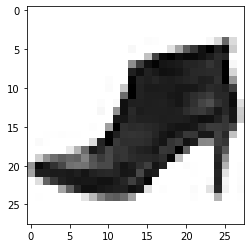

In [114]:
plt.imshow(train_x[np.random.randint(0, len(train_y))], cmap="binary")
plt.show()